In [73]:
import pandas as pd
from pandas.io import sql
import geopandas as gpd
import numpy as np
import psycopg2
import sqlalchemy
from sqlalchemy import create_engine
from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import os
import dotenv
import csv
import seaborn as sns

%matplotlib inline

In [74]:
%reload_ext dotenv
%dotenv ../.env

In [75]:
cnx = create_engine(os.getenv('EDMDB'))

In [76]:
sql.execute('''
DROP TABLE IF EXISTS dcp.pluto_points, 
dcp.irrlot_regular, dcp.irrlot_irregular
''', cnx)

In [77]:
sql.execute('''
CREATE TABLE dcp.pluto_points AS
SELECT "BBL" as bbl,
(ST_DumpPoints(geom)).path AS path,
(ST_DumpPoints(geom)).geom AS geom,
"Borough" as borough,
(ST_DumpPoints(geom)).path[1] AS path_1,
(ST_DumpPoints(geom)).path[2] AS path_2,
(ST_DumpPoints(geom)).path[3] AS path_3
FROM dcp.pluto192
WHERE geom IS NOT NULL
AND "LotArea" > 15000
AND (ST_Area(ST_OrientedEnvelope(geom)) - ST_Area(geom)) / ST_Area(geom) * 100 > 15;
''', cnx)

In [78]:
sql.execute('''
ALTER TABLE dcp.pluto_points
ADD PRIMARY KEY (bbl, path_1, path_2, path_3);
''', cnx)

In [79]:
sql.execute('''
CREATE INDEX pluto_points_geom_idx ON dcp.pluto_points USING GIST (geom);
''', cnx)

In [80]:
%run -i '../python/IrrLot.py'

Selecting points from pluto 19.1 table using cursor.fetchall
Records read:  1000
Records read:  2000
Records read:  3000
Records read:  4000
Records read:  5000
Records read:  6000
Records read:  7000
Records read:  8000
Records read:  9000
Records read:  10000
Records read:  11000
Records read:  12000
Records read:  13000
Records read:  14000
Records read:  15000
Records read:  16000
Records read:  17000
Records read:  18000
Records read:  19000
Records read:  20000
Records read:  21000
Records read:  22000
Records read:  23000
Records read:  24000
Records read:  25000
Records read:  26000
Records read:  27000
Records read:  28000
Records read:  29000
Records read:  30000
Records read:  31000
Records read:  32000
Records read:  33000
Records read:  34000
Records read:  35000
Records read:  36000
Records read:  37000
Records read:  38000
Records read:  39000
Records read:  40000
Records read:  41000
Records read:  42000
Records read:  43000
Records read:  44000
Records read:  45000
Rec

In [87]:
sql.execute('''
CREATE TABLE dcp.irrlot_irregular (
	bbl NUMERIC,
	irrlotcode VARCHAR(1),
	lotarea INTEGER,
	lotfront NUMERIC,
	lotdepth NUMERIC,
	front_depth_product NUMERIC,
	pluto_shape_area NUMERIC,
	geom GEOMETRY(MULTIPOLYGON, 2263),
	PRIMARY KEY (bbl)
);
''', cnx)

In [88]:
conn = psycopg2.connect(os.getenv('EDMCONN'))
cur = conn.cursor()
with open('../output/irregular_angles.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        cur.execute(
            "INSERT INTO dcp.irrlot_irregular VALUES ('{0}')".format(row[0])
        )
conn.commit()

In [89]:
sql.execute('''
UPDATE dcp.irrlot_irregular i
SET geom = p.geom,
irrlotcode = p."IrrLotCode",
lotarea = p."LotArea",
lotfront = p."LotFront",
lotdepth = p."LotDepth",
front_depth_product = p."LotFront" * p."LotDepth",
pluto_shape_area = p."Shape_Area"
FROM dcp.pluto192 p
WHERE i.bbl = p."BBL";
''', cnx)

This gets the total count of lots determined to be irregular that are currently classified as regular.

In [90]:
pd.read_sql_query('''
SELECT COUNT(*) AS irregular_lot_count
FROM dcp.irrlot_irregular
WHERE irrlotcode = 'N'
''', cnx)

,irregular_lot_count
0,1136


Sum the lotarea, shape_area, and differences for all records that were misclassified. Converting shape_area and difference totals to integer for readability.

In [91]:
pd.read_sql_query('''
SELECT SUM(lotarea) AS summed_lotarea,
CAST(SUM(pluto_shape_area) AS INTEGER) AS summed_shape_area,
CAST(SUM(pluto_shape_area - lotarea) AS INTEGER) AS summed_shape_area_lotarea_difference
FROM dcp.irrlot_irregular
WHERE irrlotcode = 'N'
''', cnx)

,summed_lotarea,summed_shape_area,summed_shape_area_lotarea_difference
0,177110723,166788994,-10321729


In [ ]:
Breakout by landuse code

In [92]:
landuse_breakout = pd.read_sql_query('''
SELECT p."LandUse",
d.def AS landuse_definition,
SUM(lotarea) AS lotarea,
CAST(SUM(front_depth_product) AS INTEGER) AS frontxdepth,
CAST(SUM(pluto_shape_area) AS INTEGER) AS shape_area,
CAST(SUM(pluto_shape_area - lotarea) AS INTEGER) AS shape_area_lotarea_difference
FROM dcp.irrlot_irregular i,
dcp.landuse_definitions d,
dcp.pluto192 p
WHERE i.bbl = p."BBL"
AND p."LandUse" = d.landuse
AND i.irrlotcode = 'N'
GROUP BY p."LandUse", d.def
''', cnx)

In [93]:
df = pd.DataFrame(landuse_breakout, columns=['LandUse', 'landuse_definition', 'lotarea', 'frontxdepth', 'shape_area', 'shape_area_lotarea_difference'])
df

,LandUse,landuse_definition,lotarea,frontxdepth,shape_area,shape_area_lotarea_difference
0,01,One and Two Family Buildings,3826494,3531232,3582337,-244157
1,02,Multi-Family Walkup Buildings,10298882,2564905,9584671,-714211
2,03,Multi-Family Elevator Buildings,6999638,4284430,7202802,203164
3,04,Mixed Residential and Commercial,3891387,1745949,3846050,-45337
4,05,Commercial and Office,3401190,2719715,3435852,34662
5,06,Industrial and Manufacturing,1886110,1516577,1848874,-37236
6,07,Transportation and Utility,71574803,22109996,63542226,-8032577
7,08,Public Facilities and Institutions,12616775,4672692,12947319,330544
8,09,Open Space and Outdoor Recreation,34361257,41265194,50917632,16556375
9,10,Parking Facilities,1602393,1718748,1595007,-7386


In [94]:
lotarea_list = df['lotarea'].tolist()
shape_area_list = df['shape_area'].tolist()
landuse_list = df['landuse_definition'].tolist()
front_depth_list = df['frontxdepth'].tolist()
y_axis_list = lotarea_list + shape_area_list
y_axis_list.sort()

In [95]:
sns.set()
SMALL_SIZE = 8
MEDIUM_SMALL_SIZE = 10
MEDIUM_SIZE = 11
MEDIUM_LARGE_SIZE = 14
BIGGER_SIZE = 16

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Inconsolata']
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

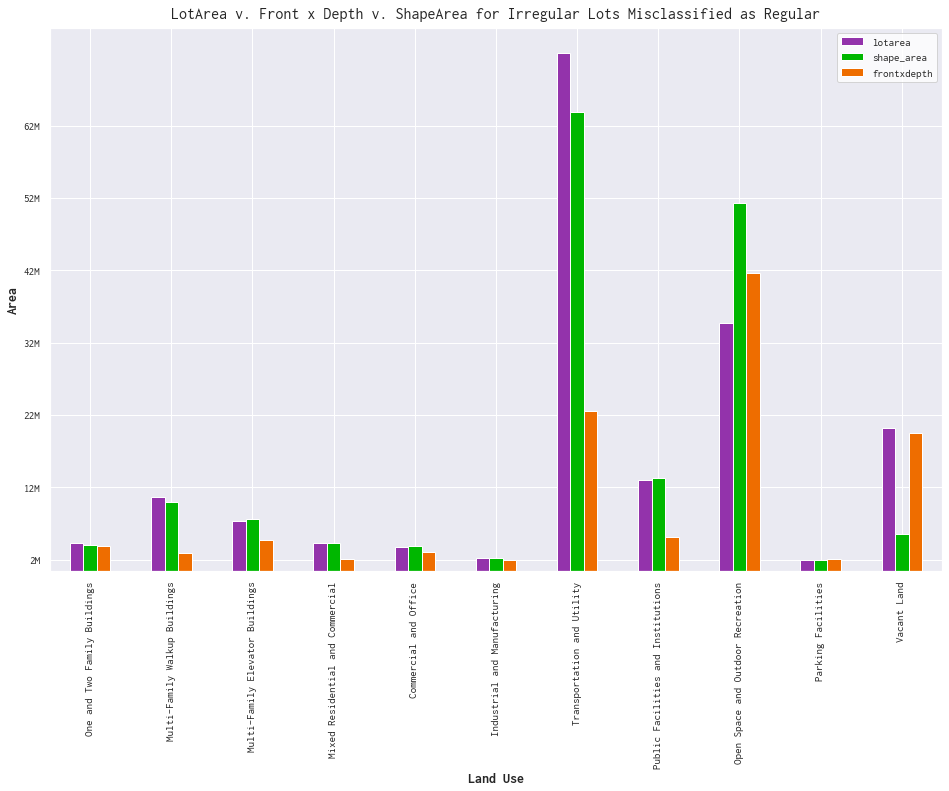

In [108]:
def y_fmt(tick_val, pos):
    if tick_val > 1000000000:
        val = round(int(tick_val) /1000000000, 1)
        return '{}B'.format(val)
    elif tick_val > 1000000:
        val = round(int(tick_val) /1000000)
        return '{}M'.format(val)
    elif tick_val > 1000:
        val = int(tick_val) / 1000
        return '{}k'.format(val)
    else:
        return tick_val

dfplot = pd.DataFrame({'lotarea': lotarea_list, 'shape_area': shape_area_list, 'frontxdepth': front_depth_list, }, index=landuse_list)
ax = dfplot.plot.bar(rot=90, figsize=(16, 10), color=['#9333AB', '#00B700', '#EE6D00'])
ax.set_xlabel("Land Use", fontweight="bold")
ax.set_ylabel("Area", fontweight="bold")
ax.ticklabel_format(useOffset=False, style='plain', axis='y')
ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
plt.xticks(np.arange(len(shape_area_list)), landuse_list)
plt.yticks(np.arange(min(y_axis_list), max(y_axis_list), 10000000))
plt.legend(loc='upper right', shadow='bool')
plt.title('LotArea v. Front x Depth v. ShapeArea for Irregular Lots Misclassified as Regular', pad=10, fontsize=16)
legend = plt.legend()
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show()

In [97]:
from ipyleaflet import Map, basemaps, GeoData, basemap_to_tiles, LayersControl, FullScreenControl, Popup, Marker
from ipywidgets import HTML

m = Map(center=(40.730610, -73.935242), zoom=11)

dark_matter_layer = basemap_to_tiles(basemaps.CartoDB.DarkMatter, close_popup_on_click=True)
m.add_layer(dark_matter_layer)

In [98]:
query = '''SELECT bbl, ST_Transform(geom, 4326) AS geom FROM dcp.irrlot_irregular WHERE irrlotcode = 'N';'''
query

"SELECT bbl, ST_Transform(geom, 4326) AS geom FROM dcp.irrlot_irregular WHERE irrlotcode = 'N';"

In [99]:
bbls = gpd.GeoDataFrame.from_postgis(sql=query, con=cnx)
bbls

,bbl,geom
0,1.006620e+09,"MULTIPOLYGON (((-74.00842 40.74806, -74.00848 ..."
1,1.007588e+09,"MULTIPOLYGON (((-73.99446 40.75340, -73.99483 ..."
2,1.015240e+09,"MULTIPOLYGON (((-73.95056 40.78524, -73.95035 ..."
3,2.023870e+09,"MULTIPOLYGON (((-73.90886 40.82800, -73.90918 ..."
4,2.039040e+09,"MULTIPOLYGON (((-73.87650 40.83799, -73.87725 ..."
...,...,...
1131,4.038720e+09,"MULTIPOLYGON (((-73.86046 40.71187, -73.86053 ..."
1132,4.139310e+09,"MULTIPOLYGON (((-73.85835 40.65925, -73.85835 ..."
1133,4.142411e+09,"MULTIPOLYGON (((-73.82637 40.64936, -73.82637 ..."
1134,4.158470e+09,"MULTIPOLYGON (((-73.77027 40.59405, -73.77034 ..."


In [104]:
bbls_layer = GeoData(geo_dataframe = bbls, 
              style={'color': 'green', 'opacity':10, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.3},
              name = 'new')

In [105]:
m.add_layer(bbls_layer)
m.add_control(LayersControl())
m.add_control(FullScreenControl())

In [106]:
for i in range(bbls.shape[0]):
    center = (bbls.loc[i, 'geom'].centroid.y,
              bbls.loc[i, 'geom'].centroid.x)
    bbl = str(list(bbls['bbl'])[i])
    marker = Marker(location=center)
    m.add_layer(marker)
    marker.popup = HTML(value=f'''<a target='_blank' href=https://zola.planning.nyc.gov/bbl/{bbl}> {bbl} </a>''')

In [103]:
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …